# Step 1: Module Imports

In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
#from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

%matplotlib inline

In [2]:
%pwd

'C:\\Users\\adesh\\Downloads'

# Step 2: Read and Process Data

In [40]:
my_path= 'C:\\Users\\adesh\\Info'

In [4]:
mydata = pd.read_csv(f'{my_path}/Titanic_full.csv')
print(mydata.shape)
mydata.head()

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Step 3: Train-Valid-Test-Split
###As per the video lecture we need to split data into 70-15-15 i.e train-valid-test in this order

In [5]:
def mydf_splitter(mydata,num_rows):
    return mydata[:num_rows].copy(),mydata[num_rows:]


mydf_train_valid,mydf_test = mydf_splitter(mydata,1100)

print(mydf_train_valid.shape,mydf_test.shape)
mydf_train_valid.head(2)

(1100, 12) (209, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


# Step 4: Data Preprocessing

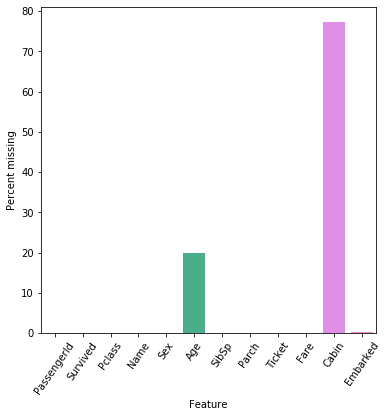

In [6]:
null_vals = mydf_train_valid.isnull().sum()/len(mydf_train_valid)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (6,6))
plt.xticks(rotation=55)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [7]:
#Above we can see that cabin column has more data missing as compared to other columns like Age, Fare and Embarked.
#Thus we will drop Cabin column because it doesn't make sense to imput 80% values in column.

mydf_train_valid_2 = mydf_train_valid.drop("Cabin",axis = 1)
print(mydf_train_valid_2.shape)
mydf_train_valid_2.head(2)

(1100, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [8]:
#The next step is to convert object type of data into category type.
#because to work with data smoothly we need either categorical or continuous
#thus check all the data types in dataset

mydf_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1100 non-null   int64  
 1   Survived     1100 non-null   int64  
 2   Pclass       1100 non-null   int64  
 3   Name         1100 non-null   object 
 4   Sex          1100 non-null   object 
 5   Age          881 non-null    float64
 6   SibSp        1100 non-null   int64  
 7   Parch        1100 non-null   int64  
 8   Ticket       1100 non-null   object 
 9   Fare         1099 non-null   float64
 10  Embarked     1098 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 94.7+ KB


In [9]:
#convert object type in to category

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [10]:
mydf_train_valid_3 = str_to_cat(mydf_train_valid_2)
mydf_train_valid_3.info()
#object type attributes like Name, Sex and Embarked are converted into category type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1100 non-null   int64   
 1   Survived     1100 non-null   int64   
 2   Pclass       1100 non-null   int64   
 3   Name         1100 non-null   category
 4   Sex          1100 non-null   category
 5   Age          881 non-null    float64 
 6   SibSp        1100 non-null   int64   
 7   Parch        1100 non-null   int64   
 8   Ticket       1100 non-null   category
 9   Fare         1099 non-null   float64 
 10  Embarked     1098 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 161.8 KB


In [11]:
#Check the cateogry mapping for Embarked and Sex column. We need this in later stage

print(mydf_train_valid_3.Embarked.cat.categories)
print(mydf_train_valid_3.Sex.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


# Impute using mean()

In [12]:
def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.mean()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [13]:
mydf_train_valid_4,my_table = mydf_preprocessor(mydf_train_valid_3,null_table = None)

In [14]:
mydf_train_valid_4.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,1,0,3,135,2,22.0,1,0,629,7.2500,3,False,False
1,2,1,1,245,1,38.0,1,0,713,71.2833,1,False,False
2,3,1,3,442,1,26.0,0,0,799,7.9250,3,False,False
3,4,1,1,354,1,35.0,1,0,56,53.1000,3,False,False
4,5,0,3,19,2,35.0,0,0,565,8.0500,3,False,False


In [15]:
my_table

{'Age': 29.81101021566402, 'Fare': 32.988257688808}

In [16]:
#take survived column out because we are trying to predict that column

Y = mydf_train_valid_4["Survived"]
X = mydf_train_valid_4.drop(["Survived"],axis = 1)

print(X.shape,Y.shape)
X

(1100, 12) (1100,)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,1,3,135,2,22.00000,1,0,629,7.2500,3,False,False
1,2,1,245,1,38.00000,1,0,713,71.2833,1,False,False
2,3,3,442,1,26.00000,0,0,799,7.9250,3,False,False
3,4,1,354,1,35.00000,1,0,56,53.1000,3,False,False
4,5,3,19,2,35.00000,0,0,565,8.0500,3,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1096,2,37,2,25.00000,0,0,669,10.5000,3,False,False
1096,1097,1,758,2,29.81101,0,0,680,25.7417,1,True,False
1097,1098,3,653,1,35.00000,0,0,615,7.7500,2,False,False
1098,1099,2,216,2,24.00000,0,0,266,10.5000,3,False,False


In [17]:
#for KNN we need to scale the continuous variables because the continuous column range can be different
#scaling would put column values between 0-1 
X_cat = X[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con = X.drop(X_cat,axis = 1)

#X_cat.head()
X_con.head(10)
#print(X_cat.shape,X_con.shape)

,Age,Fare
0,22.00000,7.2500
1,38.00000,71.2833
2,26.00000,7.9250
3,35.00000,53.1000
4,35.00000,8.0500
5,29.81101,8.4583
6,54.00000,51.8625
7,2.00000,21.0750
8,27.00000,11.1333
9,14.00000,30.0708


In [18]:
#after seperating continuous variable columns we will scale them

scaler = preprocessing.StandardScaler().fit(X_con)
X_con_sc = pd.DataFrame(scaler.transform(X_con))
X_con_sc.columns = ["Age","Fare"]
print(X_con_sc.shape)
X_con_sc.head(2)

(1100, 2)


,Age,Fare
0,-0.603658,-0.502514
1,0.632869,0.747672


In [19]:
#Now let's join categorical and scaled continuous variables together to make one dataset
df_list = [X_cat,X_con_sc]
X_full = pd.concat(df_list,axis = 1)
print(X_full.shape)
X_full.head(2)

(1100, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1,3,135,2,1,0,629,3,False,False,-0.603658,-0.502514
1,2,1,245,1,1,0,713,1,False,False,0.632869,0.747672


In [20]:
#Now lets split the data into train-validation set
X_train,X_valid = mydf_splitter(X_full,900)
Y_train,Y_valid = mydf_splitter(Y,900)

print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)

(900, 12) (200, 12) (900,) (200,)


In [21]:
#time to train the model on training set and validate its result with validation set

my_knn_model = KNeighborsClassifier(n_neighbors = 5,weights = 'uniform')
my_knn_model.fit(X_train,Y_train)

#Predict on the validation set
Y_pred = my_knn_model.predict(X_valid)

In [22]:
print(accuracy_score(Y_valid,Y_pred),
      matthews_corrcoef(Y_valid,Y_pred),f1_score(Y_valid,Y_pred))

0.54 -0.0474697036788388 0.29230769230769227


# gradient boosting

In [23]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

In [25]:
for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, Y_train)
    
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, Y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_valid, Y_valid)))

Learning rate:  0.05
Accuracy score (training): 0.778
Accuracy score (validation): 0.595
Learning rate:  0.075
Accuracy score (training): 0.807
Accuracy score (validation): 0.570
Learning rate:  0.1
Accuracy score (training): 0.807
Accuracy score (validation): 0.565
Learning rate:  0.25
Accuracy score (training): 0.838
Accuracy score (validation): 0.535
Learning rate:  0.5
Accuracy score (training): 0.844
Accuracy score (validation): 0.495
Learning rate:  0.75
Accuracy score (training): 0.850
Accuracy score (validation): 0.560
Learning rate:  1
Accuracy score (training): 0.856
Accuracy score (validation): 0.565


In [26]:
#Similarly 

# Hyperparameter tuning

In [27]:
from sklearn.metrics import accuracy_score

num_p = list()
accuracy_p =list()

num_neighs = list()
accuracy_list = list()

for neighbor in range(1,20):
    my_knn_model = KNeighborsClassifier(n_neighbors = neighbor,weights = 'uniform')
    my_knn_model.fit(X_train,Y_train)
    Y_pred = my_knn_model.predict(X_valid)
    accuracy = accuracy_score(Y_valid,Y_pred)
    num_neighs.append(neighbor)
    accuracy_list.append(accuracy)
    
for pvalue in range(1,3):
    my_knn_model_1 = KNeighborsClassifier(p = pvalue, metric= 'minkowski')
    my_knn_model_1.fit(X_train,Y_train)
    Y_pred_1 = my_knn_model_1.predict(X_valid)
    accuracy2 = accuracy_score(Y_valid,Y_pred_1)
    num_p.append(pvalue)
    accuracy_p.append(accuracy2)
    

In [28]:
eval_df =  pd.DataFrame({"Num of neighbors": num_neighs,"Valid accuracy Score": accuracy_list})
eval_df2 = pd.DataFrame({"p value": num_p, "p_accuracy": accuracy_p})
eval_df

,Num of neighbors,Valid accuracy Score
0,1,0.500
1,2,0.580
2,3,0.495
3,4,0.565
4,5,0.540
5,6,0.560
6,7,0.530
7,8,0.570
8,9,0.555
9,10,0.595


In [29]:
eval_df2

,p value,p_accuracy
0,1,0.52
1,2,0.54


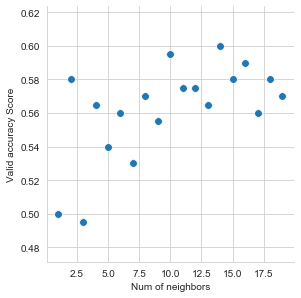

In [30]:
sns.set_style("whitegrid")
sns.pairplot(eval_df,x_vars = "Num of neighbors",
             y_vars = "Valid accuracy Score",plot_kws = {'s': 60},height = 4.0)

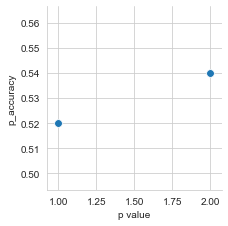

In [31]:
sns.set_style("whitegrid")
sns.pairplot(eval_df2,x_vars = "p value",
             y_vars = "p_accuracy",plot_kws = {'s': 60},height = 3.0)

In [39]:
#the value of K= 14 gives maximum accuracy of 60% and p-value= 2 with metric of "minkowski" give accuracy of 54%
knn_model_fin = KNeighborsClassifier(n_neighbors = 14,weights = 'uniform',p=2,metric='minkowski')
knn_model_fin.fit(X_full,Y)

!mkdir knn_final
knn_model_final1 = f'{my_path}\\knn_final\\knn_modelfinal.sav'
joblib.dump(knn_model_fin,knn_model_final1)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\adesh\\Info\\knn_final\\knn_modelfinal.sav'

In [37]:
#check if the model is saved
!ls knn_model

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [38]:
knn_model_loaded = joblib.load(knn_model_name)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\adesh\\Info\\knn_model\\knn_model_final2.sav'

# Evaluating test set accuracy with trained model

In [148]:
#preporcess the test set just like train-valid set
print(mydf_test.shape)
mydf_test.head(3)

(209, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,NaN,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,NaN,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,NaN,S


In [149]:
#drop Cabin colummn
mydf_test1 = mydf_test.drop("Cabin",axis = 1)
print(mydf_test1.shape)
mydf_test1.head(3)

(209, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,S


In [152]:
#Now checking the datatype of sex column
mydf_test2 = str_to_cat(mydf_test1)
mydf_test2.Sex.cat.categories

Index(['female', 'male'], dtype='object')

In [153]:
#And Embark column
mydf_test2.Embarked.cat.categories

Index(['C', 'Q', 'S'], dtype='object')

In [154]:
#impute the values like before with median
mydf_test3,my_table1 = mydf_preprocessor(mydf_test2,
                                         null_table = my_table)
print(mydf_test3.shape)
mydf_test3.head(3)

(209, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
1100,1101,1,3,47,2,25.0,0,0,106,7.8958,3,False,False
1101,1102,0,3,6,2,32.0,0,0,146,22.5250,3,False,False
1102,1103,1,3,62,2,28.0,0,0,187,7.0500,3,True,False


In [155]:
my_table1

{'Age': 28.0, 'Fare': 14.4583}

In [157]:
#split the data in X and Y variables

Y_t = mydf_test3["Survived"]
X_t = mydf_test3.drop(["Survived"],axis = 1)

print(X_t.shape,Y_t.shape)

(209, 12) (209,)


In [204]:
#seperate categorical and continuous variables so that continuous variables can be scaled

X_cat_t = X_t[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con_t = X_t.drop(X_cat_t,axis = 1)
print(X_cat_t.shape,X_con_t.shape)

(209, 10) (209, 2)


In [203]:
#scale Age and Fare columns with mean and SD

X_con_sct = pd.DataFrame(scaler.transform(X_con_t))
X_con_sct.columns = ["Age","Fare"]
print(X_con_sct.shape)
X_con_sct.head(2)

(209, 2)


,Age,Fare
0,-0.343408,-0.489547
1,0.196729,-0.203944


In [205]:
print(X_cat_t.shape, X_con_sct.shape)

(209, 10) (209, 2)


In [206]:
#reset index
X_cat_t.reset_index(inplace = True,drop = False)

In [207]:
X_cat_t.head()

,index,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1100,1101,3,47,2,0,0,106,3,False,False
1,1101,1102,3,6,2,0,0,146,3,False,False
2,1102,1103,3,62,2,0,0,187,3,True,False
3,1103,1104,2,45,2,0,0,179,3,False,False
4,1104,1105,2,91,1,1,0,38,3,False,False


In [208]:
X_cat_t.drop("index",inplace = True,axis = 1)
X_cat_t.head(2)

C:\Users\adesh\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1101,3,47,2,0,0,106,3,False,False
1,1102,3,6,2,0,0,146,3,False,False


In [209]:
#merge two set of columns i.e continuous and categorical
df_list_I = [X_cat_t,X_con_sct]
X_test_I = pd.concat(df_list_I,axis = 1)
print(X_test_I.shape)
X_test_I.head(2)

(209, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1101,3,47,2,0,0,106,3,False,False,-0.343408,-0.489547
1,1102,3,6,2,0,0,146,3,False,False,0.196729,-0.203944


In [267]:
#load saved model
kNN_loaded = joblib.load(f'{my_path}\\knn_model\\knn_model_final.sav')

In [268]:
#Test the model against testing set
Y_test_pred = kNN_loaded.predict(X_test_I)

In [270]:
print(accuracy_score(Y_t,Y_test_pred),
      matthews_corrcoef(Y_t,Y_test_pred),f1_score(Y_t,Y_test_pred))

0.5645933014354066 0.0 0.0


In [ ]:
#The performance of the model is not very good and hyperparameter of more than one attribute didnt make any difference.
#Thus we should apply different algorithm to get better accuracy
#here accuracy is 56.459%

In [ ]:
#for further calculation or programming
X_full["Survived"] = Y
X_test_I["Survived"] = Y_t

print(X_full.shape)
print(X_test_I.shape)